# Plots report

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
DATA_PATH = '../data/'
quotation = 'AAPL'
FILE_SUFFIX = '.txt'
price_column = 'Close'

In [3]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}")
data_wrapper.compute_features(predict_n=1, thresh_diff=0.005)
data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,3.070714,3.196071,3.070000,3.185714,1.155314e+09,2.748159,0.000714,60.880791,0.002857,...,3.055786,3.051339,3.068233,0.018074,-0.004446,0.117857,0.038417,higher,3.196786,stay
1,2007-02-22,3.242857,3.243214,3.161786,3.196786,8.382248e+08,2.757710,0.035000,61.709592,0.057143,...,3.067786,3.056357,3.085373,0.017140,-0.011429,0.011072,0.003476,stay,3.181072,stay
2,2007-02-23,3.184286,3.226429,3.173214,3.181072,5.178936e+08,2.744154,0.007858,59.773981,0.012500,...,3.078107,3.061393,3.098133,0.012760,-0.016714,-0.015714,-0.004916,stay,3.161072,lower
3,2007-02-26,3.208571,3.214286,3.128929,3.161072,6.158488e+08,2.726901,0.032143,57.310074,0.027499,...,3.096822,3.066982,3.106525,0.008392,-0.029839,-0.020000,-0.006287,lower,2.997500,lower
4,2007-02-27,3.082143,3.110000,2.978929,2.997500,1.145813e+09,2.585796,0.018571,42.045227,0.078929,...,3.093429,3.063393,3.091988,-0.014537,-0.030036,-0.163572,-0.051746,lower,3.021786,higher


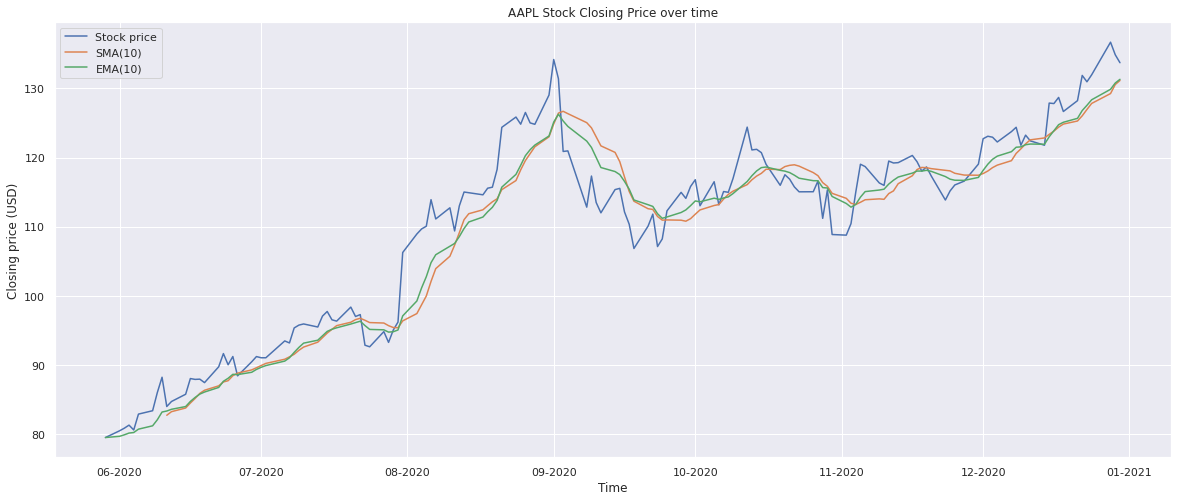

In [23]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'][-150:], data_wrapper[price_column][-150:], quotation_name=quotation, ma_values=[10], ema_values=[10])